<a href="https://colab.research.google.com/github/rogerarpagaus/Stock-Market/blob/main/PredictStockMarket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install environment with all the used libraries.
#!pip install tensorflow
#!pip install yfinance
#!pip install scikit-learn
#!pip install pandas
#!pip install matplotlip

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import datetime

In [3]:
# import to ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Step 1: Download Stock Data
# Prompt the user to enter a stock ticker symbol
ticker = input("Enter the stock ticker symbol (e.g., AAPL for Apple): ")

# Download historical data from Yahoo Finance
data = yf.download(ticker, start='2020-01-01', end=datetime.datetime.today().strftime('%Y-%m-%d'))

# Focus on 'Close' prices for simplicity
data = data[['Close']]

In [5]:
# Step 2: Preprocess Data
# Initialize MinMaxScaler to normalize the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))

# Scale the data for training
scaled_data = scaler.fit_transform(data)

In [6]:
# Step 3: Prepare Training Data
# Define training data length as 80% of the total data
training_data_len = int(np.ceil(len(scaled_data) * 0.8))

# Split the scaled data into the training set
train_data = scaled_data[0:int(training_data_len), :]

# Create empty lists for features (x_train) and target (y_train)
x_train = []
y_train = []

# Populate x_train with 60 days of data and y_train with the following day’s closing price
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0]) # Past 60 days
    y_train.append(train_data[i, 0])      # Target: the next day’s close price

# Convert lists to numpy arrays for model training
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to the format [samples, time steps, features] required for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [8]:
# Step 4: Build LSTM Model
model = Sequential()
# First LSTM layer with 50 units and return sequences
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2)) # Dropout layer to prevent overfitting
# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2)) # Dropout layer to prevent overfitting
# Dense layer with 25 units
model.add(Dense(units=25))
# Output layer with 1 unit (the predicted price)
model.add(Dense(units=1))


# Compile the model using Adam optimizer and mean squared error as the loss function
model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
# Step 5: Train the Model
# Train the model with batch size of 1 and for 1 epoch (adjust epoch count for better results)
model.fit(x_train, y_train, batch_size=1, epochs=1)

944/944 ━━━━━━━━━━━━━━━━━━━━ 33s 32ms/step - loss: 0.0101


In [10]:
# Step 6: Prepare the Data for 30-Day Forecast
# Take the last 60 days from the dataset for generating future predictions
last_60_days = scaled_data[-60:]
# Reshape last_60_days to fit the model input shape (1 sample, 60 timesteps, 1 feature)
x_future = last_60_days.reshape((1, last_60_days.shape[0], 1))

In [ ]:
# Step 7: Generate 30-Day Forecast
# Create an empty list to store predictions for the next 30 days
future_predictions = []
for _ in range(30):  # Change 30 to 60 to predict for 60 days
    # Predict the next day’s closing price based on the last 60 days
    pred = model.predict(x_future)
    future_predictions.append(pred[0, 0]) # Add prediction to the list
    # Update x_future with the new prediction by removing the first value and adding the new prediction
    x_future = np.append(x_future[:, 1:, :], [[pred[0]]], axis=1)

In [13]:
# Step 8: Transform Predictions Back to Original Scale
# Convert the scaled predictions back to the original scale using inverse_transform
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

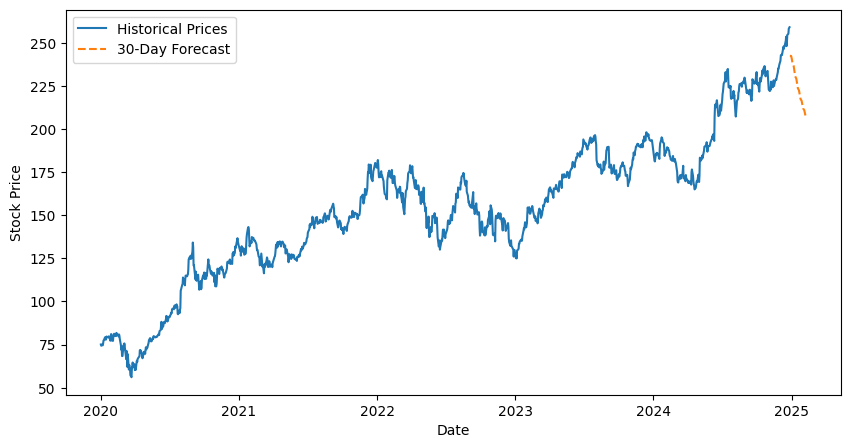

In [14]:
# Step 9: Visualize the Results
# Create a DataFrame to hold the 30-day forecast with dates
forecast_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')
forecast = pd.DataFrame(future_predictions, index=forecast_dates, columns=['Prediction'])

# Plot historical data and future predictions for comparison
plt.figure(figsize=(10, 5))
plt.plot(data['Close'], label='Historical Prices')
plt.plot(forecast, label='30-Day Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()